In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

model = SentenceTransformer("all-MiniLM-L6-v2")

def combine_text(row):
    return (
        f"title: {row['title']}. "
        f"overview: {row['overview']}. "
        f"director: {row['director']}. "
        f"Directed by {row['director']}."
    )

In [2]:
df = pd.read_csv("TMDB_all_movies.csv")

In [3]:
df = df[df["revenue"].notnull() & (df["revenue"] > 1_000_000)]
parsed_dates = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = parsed_dates.dt.year
df = df[df["release_year"].notnull() & (df["release_year"] >= 1980)]
print(df['revenue'].describe())

count    1.242300e+04
mean     6.182690e+07
std      1.483170e+08
min      1.000071e+06
25%      4.017507e+06
50%      1.350000e+07
75%      5.011080e+07
max      2.923706e+09
Name: revenue, dtype: float64


In [4]:
cpi_map = {
    1960: 29.6,
    1970: 38.8,
    1980: 82.4,
    1990: 130.7,
    2000: 172.2,
    2010: 218.1,
    2015: 237.0,
    2020: 258.8,
    2021: 270.97,
    2022: 292.66,
    2023: 303.0,
    2024: 313.0,
    2025: 315.6  # estimated
}

def interpolate_cpi(year: int) -> float:
    if year in cpi_map:
        return cpi_map[year]

    # Convert to sorted list
    known_years = sorted(cpi_map.keys())
    
    # Find closest years before and after
    prev_years = [y for y in known_years if y < year]
    next_years = [y for y in known_years if y > year]

    if not prev_years or not next_years:
        return np.nan  # Can't interpolate outside known range

    y1 = max(prev_years)
    y2 = min(next_years)
    cpi1 = cpi_map[y1]
    cpi2 = cpi_map[y2]

    # Linear interpolation with weighting based on distance
    weight = (year - y1) / (y2 - y1)
    return cpi1 * (1 - weight) + cpi2 * weight
    
def adjust_for_inflation(amount: float, release_year: int, base_year: int = 2025) -> float:
    try:
        base_cpi = cpi_map[base_year]
        movie_cpi = cpi_map.get(release_year) or interpolate_cpi(release_year)
        if not movie_cpi:
            return amount  # fallback if CPI is still missing
        return amount * (base_cpi / movie_cpi)
    except Exception:
        return amount
df['budget_adj'] = df.apply(
    lambda row: adjust_for_inflation(row['budget'], row['release_year']), axis=1
)

df['revenue_adj'] = df.apply(
    lambda row: adjust_for_inflation(row['revenue'], row['release_year']), axis=1
)
print(df['revenue_adj'].describe())

count    1.242300e+04
mean     9.606349e+07
std      2.150587e+08
min      1.000526e+06
25%      6.198475e+06
50%      2.235727e+07
75%      8.476569e+07
max      4.473049e+09
Name: revenue_adj, dtype: float64


In [5]:
# def truncate_cast(cast_str):
#     return ', '.join(cast_str.split(', ')[:5]) 
# df['cast'] = df['cast'].apply(truncate_cast)

In [20]:
df['search_text'] = df.fillna('').apply(combine_text, axis=1)
embeddings = model.encode(df['search_text'].tolist(), show_progress_bar=True, convert_to_numpy=True)
embedding_dim = embeddings.shape[1]
print(embeddings.shape)
print(embeddings.dtype)
#index = faiss.IndexHNSWFlat(embedding_dim, 16)
#index.hnsw.efConstruction = 40
#index.hnsw.efSearch = 32
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)


Batches:   0%|          | 0/389 [00:00<?, ?it/s]

/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


(12423, 384)
float32


In [31]:
def query_movies(user_query, k=10, distance_threshold=0.1):
    query_vec = model.encode([user_query], convert_to_numpy=True)
    D, I = index.search(query_vec, k)
    mask = D[0] < distance_threshold
    print(D)
    results = df.iloc[I[0]].copy()

    revenues = results['revenue'].dropna()
    if len(revenues) == 0:
        return results, None

    revenue_stats = {
        "min": revenues.min(),
        "max": revenues.max(),
        "median": revenues.median(),
        "mean": revenues.mean()
    }
    return results, revenue_stats
    
user_input = "black comedy directed by  nolan"
results, stats = query_movies(user_query=user_input, k=10, distance_threshold=0.5)

print("Top similar movies:")
print(results[['title', 'revenue_adj']])

if stats:
    print("\nEstimated revenue range (in millions USD):")
    print(f"Min: ${stats['min'] / 1e6:,.1f}M")
    print(f"Max: ${stats['max'] / 1e6:,.1f}M")
    print(f"Median: ${stats['median'] / 1e6:,.1f}M")
    print(f"Mean: ${stats['mean'] / 1e6:,.1f}M")

[[0.9564078  0.97818613 0.9817041  1.022214   1.0244305  1.036104
  1.0418078  1.0531331  1.0575299  1.0585657 ]]
Top similar movies:
                            title   revenue_adj
619713                Oppenheimer  9.915881e+08
711118             The Blackening  1.666535e+07
267                      Insomnia  1.978631e+08
116               The Dark Knight  1.517512e+09
4846             The Black Dahlia  7.759835e+07
96474                Interstellar  1.010330e+09
16688              The Black Room  7.404910e+06
251372   Batman: The Killing Joke  4.936153e+06
17634   White Hunter, Black Heart  5.553787e+06
1270                  Vanilla Sky  3.630825e+08

Estimated revenue range (in millions USD):
Min: $2.2M
Max: $1,004.6M
Median: $81.4M
Mean: $309.4M


/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


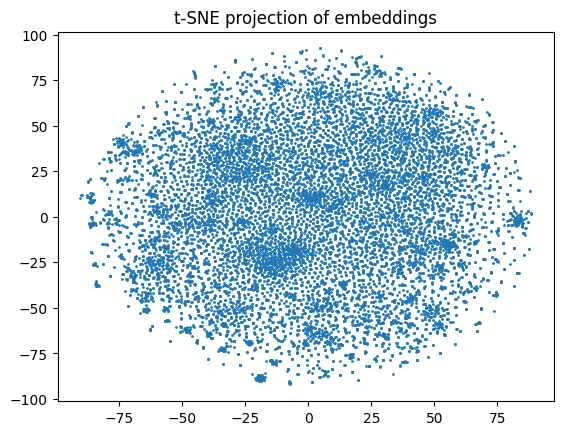

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

reduced = TSNE(n_components=2, perplexity=30).fit_transform(embeddings)

plt.scatter(reduced[:, 0], reduced[:, 1], s=1)
plt.title("t-SNE projection of embeddings")
plt.show()

In [33]:
import joblib

faiss.write_index(index, "faiss_text_only.idx")
joblib.dump(df[["title", "overview", "cast", "director", "revenue"]].reset_index(drop=True), "metadata.pkl")

['metadata.pkl']